# Exemple de krigeage 1D

## Remerciements

Merci à Régis Lebrun pour son aide sur ce thème.

## Références

* Metamodeling with Gaussian processes, Bertrand Iooss, EDF R&D, 2014, www.gdr-mascotnum.fr/media/sssamo14_iooss.pdf
* https://github.com/openturns/www/blob/master/_images/scripts/plot_kriging.py
* http://trac.openturns.org/ticket/961
* http://trac.openturns.org/ticket/959
* http://trac.openturns.org/ticket/960

## Résumé

Dans ce segment, nous présentons comment créer un métamodèle de krigeage pour une fonction dont l'entrée et la sortie sont des variables réelles scalaires. Nous montrons comment créer la base d'apprentissage et la base de validation. Nous montrons comment créer le modèle de krigeage en choisissant une tendance et un modèle de covariance. Pour finir, nous montrons comment évaluer un intervalle de confiance du krigeage en exploitant la variance de krigeage. 

## Introduction

Dans cet exemple, nous considérons la fonction sinus :
$$
y = \sin(x)
$$
pour $x\in[0,12]$. 

Nous souhaitons réaliser un métamodèle de cette fonction. Dans ce but, nous considérons un ensemble de $n$ observations de la fonction :
$$
y_i = \sin(x_i)
$$
pour $i=1,...,7$, où $x_i$ est la i-ème abscisse et $y_i$ est l'ordonnée correspondante. 

Pour cela, nous considérons les 7 abscisses suivantes :

| $i$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
|---|---|---|---|---|---|---|---|
| $x_i$ | 1 | 3 | 4 | 6 | 7.9 | 11 | 11.5 |

Nous allons considérer un métamodèle de krigeage associé à :
* une tendance constante,
* un noyau de covariance de Matern. 

## Create the function and get the data

Nous allons créer le méta-modèle avec OpenTURNS. Nous commençons par définir la fonction `g` comme une fonction symbolique. Puis nous définissons la variable `x_train` qui contient les abscisses du plan d'expériences, c'est à dire le plan d'expériences d'apprentissage. Puis, nous calculons les ordonnées `y_train` correspondantes. La variable `n_train` contient la taille de la base d'apprentissage.

In [1]:
import numpy as np
import openturns as ot

In [2]:
g = ot.SymbolicFunction(["x"], ["sin(x)"])

In [29]:
input_dataset = [
    1.0,
    3.0,
    4.0,
    6.0,
    7.9,
    11.0,
    11.5,
]  # Question: how to add a point to this dataset?
x_train = ot.Sample([[x] for x in input_dataset])
y_train = g(x_train)
n_train = x_train.getSize()
n_train

7

Pour comparer la fonction et son métamodèle, nous allons utiliser une base de validation constituée d'une grille régulière de 100 points régulièrement répartis entre 0 et 12. Puis nous convertissons cette base en `Sample` et nous calculons les valeurs de la fonction en ces points.  

In [4]:
xmin = -0.5
xmax = 12.5
n_test = 100
step = (xmax - xmin) / (n_test - 1)
myRegularGrid = ot.RegularGrid(xmin, step, n_test)
x_test_coord = myRegularGrid.getValues()
x_test = ot.Sample([[x] for x in x_test_coord])
y_test = g(x_test)

Pour observer la fonction et la position des points de la base d'apprentissage, nous réalisons le graphique suivant.

In [5]:
def plot_data_test(x_test, y_test):
    """Plot the data (x_test,y_test) as a Curve, in dashed black"""
    graphF = ot.Curve(x_test, y_test)
    graphF.setLegend("Exact")
    graphF.setColor("black")
    graphF.setLineStyle("dashed")
    return graphF

In [6]:
def plot_data_train(x_train, y_train):
    """Plot the data (x_train,y_train) as a Cloud, in red"""
    graph_train = ot.Cloud(x_train, y_train)
    graph_train.setColor("red")
    graph_train.setLegend("Donnees")
    return graph_train

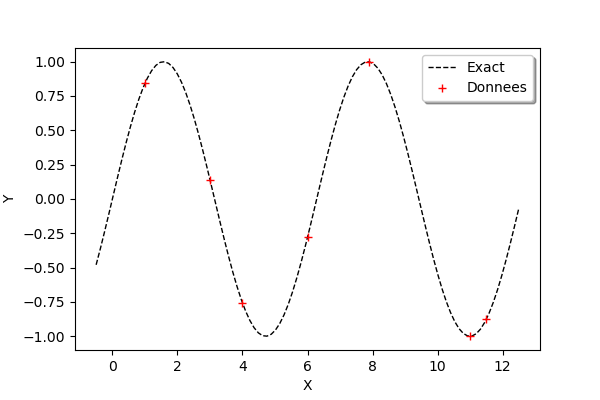

In [7]:
graph = ot.Graph()
graph.add(plot_data_test(x_test, y_test))
graph.add(plot_data_train(x_train, y_train))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph

## Fit the Kriging metamodel

Pour définir la tendance, nous utilisons la classe `ConstantBasisFactory`. La classe `MaternModel` permet de créer un modèle de covariance de Matern, associé au paramètre $\nu=3/2$.

In [8]:
dimension = 1
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.MaternModel([1.0] * dimension, 1.5)
algo = ot.KrigingAlgorithm(x_train, y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
print(result)

KrigingResult(covariance models=MaternModel(scale=[1.27453], amplitude=[0.822263], nu=1.5), covariance coefficients=0 : [  1.13904    ]
1 : [  1.01762    ]
2 : [ -1.76279    ]
3 : [ -0.559148   ]
4 : [  1.78757    ]
5 : [ -1.61946    ]
6 : [ -0.00283262 ], basis=[Basis( [class=LinearEvaluation name=Unnamed center=[0] constant=[1] linear=[[ 0 ]]] )], trend coefficients=[[0.00736751]])


On observe que les paramètres d'échelle `scale` et d'amplitude on été optimisés par la méthode `run`. Puis, on récupère le métamodèle avec la méthode `getMetaModel` et on évalue la valeur du métamodèle sur la base de test.

In [21]:
metamodel = result.getMetaModel()
y_test_MM = metamodel(x_test)

Dans le but de comparer la valeur du méta-modèle avec la valeur du modèle sur la base de test, on réalise le graphique suivant. 

In [22]:
def plot_data_kriging(x_test, y_test_MM):
    """Plots (x_test,y_test_MM) from the metamodel as a Curve, in blue"""
    graphK = ot.Curve(x_test, y_test_MM)
    graphK.setColor("blue")
    graphK.setLegend("Krigeage")
    return graphK

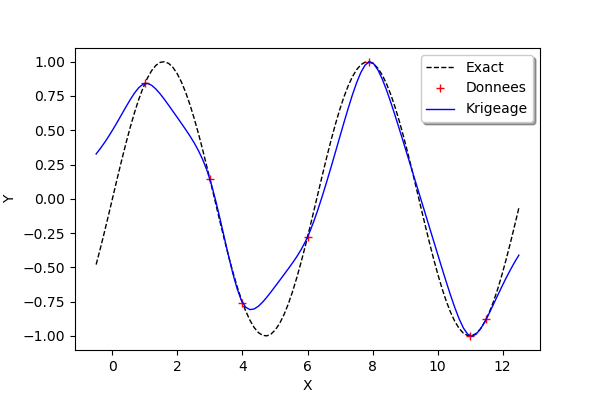

In [23]:
graph = ot.Graph()
graph.add(plot_data_test(x_test, y_test))
graph.add(plot_data_train(x_train, y_train))
graph.add(plot_data_kriging(x_test, y_test_MM))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph

On observe que, lorsque la fonction sinus a une forte courbure entre deux points d'apprentissage assez espacés, alors le métamodèle de krigeage n'est pas très proche de la fonction g. 

## Validate the kriging metamodel

In [26]:
validation = ot.MetaModelValidation(x_test, y_test, metamodel)
Q2 = validation.computePredictivityFactor()[0]
Q2

0.9022815482523787

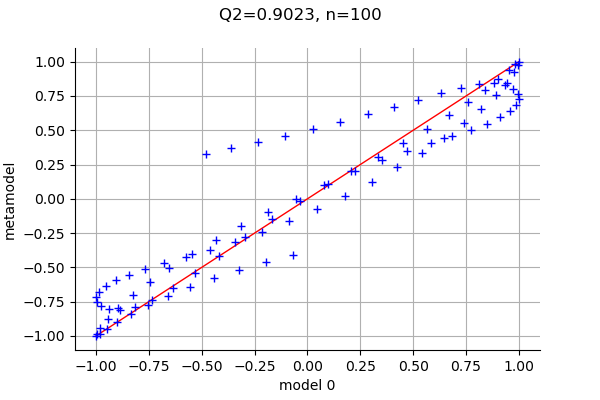

In [28]:
graph = validation.drawValidation()
graph.setTitle("Q2=%.4f, n=%d" % (Q2, n_test))
graph

## Generate trajectories from the conditional Gaussian process

In [12]:
krv = ot.KrigingRandomVector(result, x_test)
number_of_curves = 5
krv_sample = krv.getSample(number_of_curves)

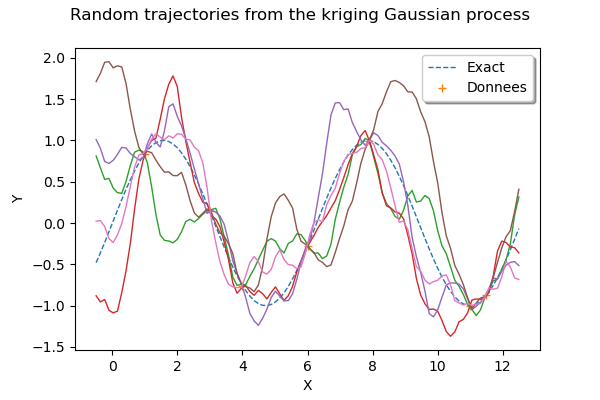

In [13]:
graph = ot.Graph()
graph.setTitle("Random trajectories from the kriging Gaussian process")
graph.setXTitle("X")
graph.setYTitle("Y")
graph.add(plot_data_test(x_test, y_test))
graph.add(plot_data_train(x_train, y_train))
graph.setAxes(True)
graph.setLegendPosition("topright")
for i in range(number_of_curves):
    kriging_trajectory = ot.Sample([[x] for x in krv_sample[i, :]])
    curve = ot.Curve(x_test, kriging_trajectory)
    graph.add(curve)
graph.setColors(ot.Drawable_BuildDefaultPalette(2 + number_of_curves))
graph

Pour diminuer la variance de krigeage, on peut estimer la variance de krigeage et calculer un intervalle de confiance gaussien à 95% contenant le processus gaussien. 

On commence par définir la variable `alpha` contenant le complémentaire du niveau souhaité pour l'intervalle de confiance. Puis on calcule le quantile de la loi gaussienne correspondant à `1-alpha/2`. Ainsi l'intervalle de confiance est 
$$
P\in\left(X\in\left[q_{\alpha/2},q_{1-\alpha/2}\right]\right)=1-\alpha.
$$

In [14]:
N = ot.Normal()
alpha = 0.05
bilateralCI = N.computeBilateralConfidenceInterval(1 - alpha)
print("alpha=%f" % (alpha))
quantileAlpha = bilateralCI.getUpperBound()[0]
print("Quantile alpha=%f" % (quantileAlpha))

alpha=0.050000
Quantile alpha=1.959964


Pour estimer l'erreur de krigeage, on peut considérer l'évolution de la variance conditionnelle. La méthode `getConditionalCovariance` renvoit la matrice de covariance `covGrid` évaluée en les points en argument de la méthode. Puis, on peut utiliser les termes diagonaux de cette matrice pour accéder à la variance de krigeage. Puisque c'est une variance, nous utilisons la racine carrée pour évaluer un écart-type, dont l'unité est comparable avec celle de la sortie.

A ce sujet, voir la PR suivante au sujet de la méthode `getConditionalMarginalVariance` qui sera disponible dans OT 1.14 :

https://github.com/openturns/openturns/pull/1195

Si un des points de la base d'apprentissage est également dans la base de validation, alors une erreur est générée :

    RuntimeWarning: invalid value encountered in sqrt
   
En effet, la matrice de covariance devient singulière dans ce cas, de telle sorte que le krigeage est indéfini en ce point. Il y a deux méthodes pour résoudre ce problème. La première consiste à retirer chaque point de la base de validation qui se trouve également dans la base d'apprentissage. La seconde consiste à ajouter un effet "pépite", d'amplitude proche de zéro, et qui agit comme un facteur de régularisation du krigeage. 

In [15]:
covGrid = result.getConditionalCovariance(x_test)
conditionalStDev = ot.Sample([[np.sqrt(covGrid[i, i])] for i in range(n_test)])

La figure suivante présente l'écart-type conditionnel en fonction de $x$.

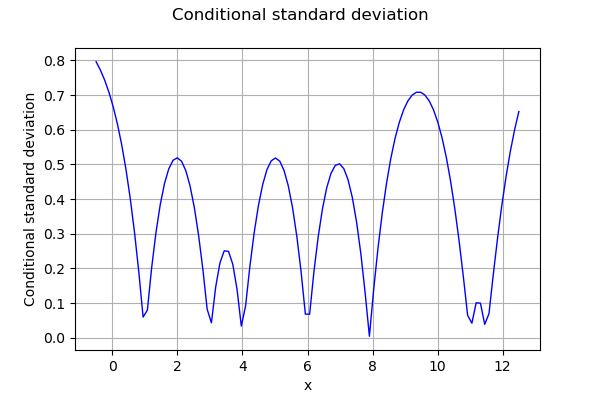

In [16]:
graph = ot.Graph(
    "Conditional standard deviation", "x", "Conditional standard deviation", True, ""
)
curve = ot.Curve(x_test, conditionalStDev)
graph.add(curve)
graph

In [17]:
dataLower = [
    [y_test_MM[i, 0] - quantileAlpha * conditionalStDev[i, 0]] for i in range(n_test)
]
dataUpper = [
    [y_test_MM[i, 0] + quantileAlpha * conditionalStDev[i, 0]] for i in range(n_test)
]
dataLower = ot.Sample(dataLower)
dataUpper = ot.Sample(dataUpper)

Pour créer le graphique des bornes de l'intervalle de confiance, on utilise la classe `Polygon` dans le but de créer une surface colorée associée à l'intervalle de confiance. Pour cela, on commence par générer les sommets des polygones en bas `vLow` et en haut `vUp`. Puis on assemble les sommets pour former les polygônes. 

In [18]:
vLow = [[x_test[i, 0], dataLower[i, 0]] for i in range(n_test)]
vUp = [[x_test[i, 0], dataUpper[i, 0]] for i in range(n_test)]

In [19]:
def plot_kriging_bounds(vLow, vUp, n_test):
    palette = ot.Drawable.BuildDefaultPalette(2)
    myPaletteColor = palette[1]
    polyData = [[vLow[i], vLow[i + 1], vUp[i + 1], vUp[i]] for i in range(n_test - 1)]
    polygonList = [
        ot.Polygon(polyData[i], myPaletteColor, myPaletteColor)
        for i in range(n_test - 1)
    ]
    boundsPoly = ot.PolygonArray(polygonList)
    boundsPoly.setLegend("95% bounds")
    return boundsPoly

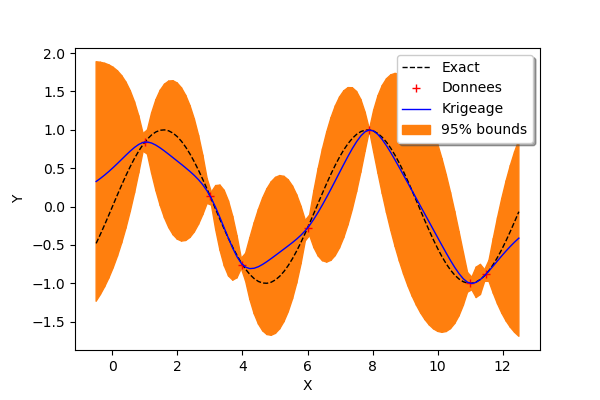

In [20]:
graph = ot.Graph()
graph.add(plot_data_test(x_test, y_test))
graph.add(plot_data_train(x_train, y_train))
graph.add(plot_data_kriging(x_test, y_test_MM))
graph.add(plot_kriging_bounds(vLow, vUp, n_test))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph

## Exercice 1 : choix du prochain point

On observe que, pour certains zones de l'espace, le krigeage est de moins bonne qualité. On peut le voir, bien sûr, en comparant la valeur prédite par le métamodèle et la valeur exacte. On observe de plus, que la variance de krigeage est souvent élevée dans les zones où le métamodèle est de mauvaise qualité. 

*Questions*

* Si l'on devait choisir un huitième point et l'ajouter à la base d'apprentissage, comment pourrions-nous choisir ce point ? Pour cela, observer le graphique de l'écart-type conditionnel et identifier le point $x$ qui maximise cet écart-type. 
* Modifier la variable `x_train` (au début du Notebook) et ajouter le point d'entrée $x$ dans la liste. 
* Exécuter les cellules suivantes et observer:
 * dans le graphique présentant l'évolution de la fonction comparée à celle du krigeage, que le nouveau krigeage possède un nouveau point d'interpolation, 
 * dans le graphique présentant l'évolution de l'écart-type conditionnel en fonction de $x$, que l'écart-type est désormais nul en ce point, 
 * dans le graphique présentant l'évolution de la fonction et de son intervalle de confiance à 95%, que l'incertitude est désormais réduite en ce point. 
* Ajouter ainsi successivement 6 points dans le plan d'expériences. Qu'observez-vous ? Comment cela se généralise-t-il en dimension supérieure ?

## Exercice 2 : impact de l'estimation des hyperparamètres

L'objet `algo` qui est une instance de la classe `KrigingAlgorithm` dispose d'une méthode `setOptimizeParameters` qui permet d'activer ou désactiver l'estimation des hyperparamètres du modèle de covariance par la méthode du maximum de vraisemblance. 

*Questions*

* Désactiver cet optimisation avec l'instruction 
```
algo.setOptimizeParameters(False)
```
et observer le résultat.
* Quel est l'impact sur les hyperparamètres `scale` et `amplitude` ?
* Quel est l'impact sur l'espérance conditionnelle ?
* Quel est l'impact sur la variance conditionnelle ?

## Exercice 3 : impact du modèle de covariance

Dans l'exemple, nous avons utilisé le modèle de Matern comme modèle de covariance. 

*Questions*

* Utiliser le modèle `SquaredExponential` avec les paramètres suivants 

```
covarianceModel = ot.SquaredExponential([0.3], [1.0])
```

*et* désactiver l'optimisation des hyperparamètres par maximum de vraisemblance.
La prédiction est-elle de meilleure qualité qu'avec le modèle de Matern ?
* Réactiver l'optimisation des hyperparamètres : que se passe-t-il ?